In [12]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import numpy as np
import openpyxl
import math

1


In [13]:
# list of team names currently in associated leagues (including relegated teams from last season to fill DF), as they are displayed on Understat.

epl_rank = ['Manchester City', 'Arsenal', 'Liverpool', 'Manchester United', 'Newcastle United', 'Tottenham', 'Brighton',
            'Aston Villa', 'Brentford', 'Chelsea', 'Fulham', 'Crystal Palace', 'Wolverhampton Wanderers', 'Everton',
            'West Ham', 'Nottingham Forest', 'Bournemouth', 'Leicester', 'Southampton','Burnley','Luton','Sheffield United',
            'Leeds']
ligue1_rank = ['Ajaccio', 'Marseille', 'Auxerre', 'Lens', 'Monaco', 'Toulouse', 'Nantes', 'Angers', 'Lorient',
               'Strasbourg', 'Nice', 'Lyon', 'Paris Saint Germain', 'Clermont Foot', 'Brest', 'Rennes', 'Reims',
               'Montpellier', 'Troyes', 'Lille','Metz','Le Havre']
bundesliga_rank = ['Borussia Dortmund', 'Mainz 05', 'RasenBallsport Leipzig', 'Schalke 04', 'Union Berlin',
                   'Werder Bremen', 'FC Cologne', 'Bayern Munich', 'Borussia M.Gladbach', 'Augsburg',
                   'Eintracht Frankfurt', 'Freiburg', 'Wolfsburg', 'Hertha Berlin', 'Bochum', 'Bayer Leverkusen',
                   'VfB Stuttgart', 'Hoffenheim','FC Heidenheim','Darmstadt']
serieA_rank = ['Sassuolo', 'Fiorentina', 'Torino', 'Inter', 'Cremonese', 'Salernitana', 'Empoli', 'Lazio', 'Napoli',
               'Sampdoria', 'Atalanta', 'Monza', 'Lecce', 'Bologna', 'AC Milan', 'Verona', 'Roma', 'Spezia', 'Udinese',
               'Juventus','Cagliari','Frosinone','Genoa']
laliga_rank = ['Real Madrid', 'Athletic Club', 'Villarreal', 'Athletico Madrid', 'Celta Vigo', 'Barcelona',
               'Real Valladolid', 'Getafe', 'Elche', 'Cadiz', 'Espanyol', 'Almeria', 'Osasuna', 'Girona', 'Real Betis',
               'Valencia', 'Mallorca', 'Rayo Vallecano', 'Real Sociedad', 'Sevilla','Granada','Alaves','Las Palmas']

1


In [14]:
# Match IDs on Understat:

# 2022/23
# ENG - 18202 - 18581 (380, 38*10)
eng22_23 = [a + 18202 for a in range(0,380)]
eng22_23_count = 0
# FRA - 19648 - 20027 (380, 38*10)
fra22_23 = [a + 19648 for a in range(0,380)] #20 teams last season
fra22_23_count = 0
# GER - 19342 - 19647 (306, 34*9)
ger22_23 = [a + 19342 for a in range(0,306)]
ger22_23_count = 0
# ITA - 18582 - 18961 (380, 38*10)
ita22_23 = [a + 18582 for a in range(0,380)]
ita22_23_count = 0
# SPA - 18962 - 19341 (380, 38*10)
spa22_23 = [a + 18962 for a in range(0,380)]
spa22_23_count = 0
# RUS - 20028 - 20267 (240, 30*8) - data ignored for now

#2023/24
# ENG - 21925 - 22304
eng23_24 = [a + 21925 for a in range(0,380)]
eng23_24_count = 0
# FRA - 23371 - 23676
fra23_24 = [a + 23371 for a in range(0,306)] #18 teams this season
fra23_24_count = 0
# GER - 23065 - 23370
ger23_24 = [a + 23065 for a in range(0,306)]
ger23_24_count = 0
# ITA - 22305 - 22684
ita23_24 = [a + 22305 for a in range(0,380)]
ita23_24_count = 0
# SPA - 22685 - 23064
spa23_24 = [a + 22685 for a in range(0,380)]
spa23_24_count = 0
# RUS - 21685 - 21924 - data ignored for now

eng_df = pd.DataFrame()
fra_df = pd.DataFrame()
ger_df = pd.DataFrame()
ita_df = pd.DataFrame()
spa_df = pd.DataFrame()                        


1


In [15]:
# webscraping understat for match data

def matchstat_generator(league_count,ov_df):
    
    # reset df
    ov_df = ov_df.drop(ov_df.index, inplace=True)

    for match_id in league_count:
    
        base_url ='https://understat.com/match/'
        url = base_url+str(match_id)
        
        res = requests.get(url)
        soup = BeautifulSoup(res.content, 'lxml')
        scripts = soup.find_all('script')

        strings = scripts[1].string

        ind_start = strings.index("('")+2
        ind_end = strings.index("')")
        json_data = strings[ind_start:ind_end]
        json_data = json_data.encode('utf8').decode('unicode_escape')

        data = json.loads(json_data)

        date = []
        x = []
        y = []
        xG = []
        result = []
        team = []
        minute = []
        data_away = data['a']
        data_home = data['h']

        for index in range(len(data_home)):
            for key in data_home[index]:
                # print(key)
                if key == 'date':
                    date.append(data_home[index][key])
                if key == 'X':
                    x.append(data_home[index][key])
                if key == 'Y':
                    y.append(data_home[index][key])
                if key == 'h_team':
                    team.append(data_home[index][key])
                if key == 'xG':
                    xG.append(float(data_home[index][key]))
                if key == 'result':
                    result.append(data_home[index][key])
                if key == 'minute':
                    minute.append(data_home[index][key])

        for index in range(len(data_away)):
            for key in data_away[index]:
                if key == 'date':
                    date.append(data_away[index][key])
                if key == 'X':
                    x.append(data_away[index][key])
                if key == 'Y':
                    y.append(data_away[index][key])
                if key == 'a_team':
                    team.append(data_away[index][key])
                if key == 'xG':
                    xG.append(float(data_away[index][key]))
                if key == 'result':
                    result.append(data_away[index][key])
                if key == 'minute':
                    minute.append(data_away[index][key])

        col_names = ['date','x','y','xG','result','team','minute']

        df_orig = pd.DataFrame([date,x,y,xG,result,team,minute],index=col_names)

        df = df_orig.T
        df['minute'] = df['minute'].astype(int)
        

        # team retrieval
        team_list = []
        sorted_team_list = []
        team_list.append(df.team.unique())
        home_team = team_list[0][0]
        away_team = team_list[0][1]
        sorted_team_list.append(home_team)
        sorted_team_list.append(away_team)
        sorted_team_list.sort()
        date = date[0]

        # xG and xGC sum
        expected_data_sums = df.groupby([team]).xG.sum().reset_index()

        if sorted_team_list[0] == home_team:
            xG_home = round(expected_data_sums.xG[0],3)
            xG_away = round(expected_data_sums.xG[1],3)
        else:
            xG_home = round(expected_data_sums.xG[1],3)
            xG_away = round(expected_data_sums.xG[0],3)

        # Shots faced sum
        shot_data_sums = df.groupby([team]).xG.count().reset_index()

        if sorted_team_list[0] == home_team:
            shots_h = shot_data_sums.xG[0]
            shots_a = shot_data_sums.xG[1]
        else:
            shots_h = shot_data_sums.xG[1]
            shots_a = shot_data_sums.xG[0]

        # Quality shots faced sum (over .25 xG)
        h_quality_shot_data_sums = len(df[(df["team"] == home_team) & (df["xG"] >= 0.25)])
        a_quality_shot_data_sums = len(df[(df["team"] == away_team) & (df["xG"] >= 0.25)])

        #goals
        home_array = [home_team]
        away_array = [away_team]
        home_goal_loc = df.loc[(df['result'] == 'Goal') & df['team'].isin(home_array)] # + (df.loc[(df['result'] == 'OwnGoal') & df['team'].isin(away_array)])
        away_goal_loc = df.loc[(df['result'] == 'Goal') & df['team'].isin(away_array)] # + (df.loc[(df['result'] == 'OwnGoal') & df['team'].isin(home_array)])
        away_own_goal_loc = df.loc[(df['result'] == 'OwnGoal') & df['team'].isin(away_array)]
        home_own_goal_loc = df.loc[(df['result'] == 'OwnGoal') & df['team'].isin(home_array)]
        home_goal_loc = home_goal_loc.merge(away_own_goal_loc,how='outer')
        away_goal_loc = away_goal_loc.merge(home_own_goal_loc,how='outer')
        first_goal_h = home_goal_loc.minute.min()
        first_goal_a = away_goal_loc.minute.min()

        if math.isnan(first_goal_h) is False and math.isnan(first_goal_a) is False:
            if first_goal_h > first_goal_a:
                first_h = 0
                first_a = 1
            elif first_goal_h < first_goal_a:
                first_h = 1
                first_a = 0
            else:
                first_h = 2
                first_a = 2
        elif math.isnan(first_goal_h) is True and math.isnan(first_goal_a) is False:
            first_h = 0
            first_a = 1
        elif math.isnan(first_goal_h) is False and math.isnan(first_goal_a) is True:
            first_h = 1
            first_a = 0
        else:
            first_h = 0
            first_a = 0


        home_goals = len(home_goal_loc)
        away_goals = len(away_goal_loc)

        # points
        if home_goals > away_goals:
            points_home = 3
            points_away = 0
        elif home_goals < away_goals:
            points_home = 0
            points_away = 3
        else:
            points_home = 1
            points_away = 1
        
        # id
        game_id_h = home_team+str(match_id)
        game_id_a = away_team+str(match_id)

        # btts
        if home_goals >= 1 and away_goals >= 1:
            btts = 1
            cs = 0
            blank = 0
        elif home_goals >= 1 and away_goals == 0:
            btts = 0
            cs = 1
            blank = 0
        elif home_goals == 0 and away_goals >= 1:
            btts = 0
            cs = 0
            blank = 1
        else:
            btts = 0
            cs = 1
            blank = 1

        df2_1 = pd.DataFrame([[date,game_id_h,home_team,"h",xG_home,xG_away,home_goals,away_goals,shots_h,shots_a,h_quality_shot_data_sums,a_quality_shot_data_sums,points_home,away_team,btts,blank,cs,first_h,first_a]],columns=['date','ID','Team','H/A','xG','xGC','G','GC','S','SC','QS','QSC','Pts','Opp','BTTS','Blank','CS','first_goal','first_conc'])
        df2_2 = pd.DataFrame([[date,game_id_a,away_team,"a",xG_away,xG_home,away_goals,home_goals,shots_a,shots_h,a_quality_shot_data_sums,h_quality_shot_data_sums,points_away,home_team,btts,cs,blank,first_a,first_h]],columns=['date','ID','Team','H/A','xG','xGC','G','GC','S','SC','QS','QSC','Pts','Opp','BTTS','Blank','CS','first_goal','first_conc'])
        df3 = pd.concat([df2_1,df2_2])
        ov_df = pd.concat([ov_df,df3])

    return ov_df   

1


In [16]:
eng_ov = sorted(eng22_23 + eng23_24)
eng_active = []
eng_count = 0

fra_ov = sorted(fra22_23 + fra23_24)
fra_active = []
fra_count = 0

ger_ov = sorted(ger22_23 + ger23_24)
ger_active = []
ger_count = 0

ita_ov = sorted(ita22_23 + ita23_24)
ita_active = []
ita_count = 0

spa_ov = sorted(spa22_23 + spa23_24)
spa_active = []
spa_count = 0

def id_list_update_380(ov,active,counter):
    while counter < 380:
        for item in reversed(ov):
            base_url ='https://understat.com/match/'
            url = base_url+str(item)
            res = requests.get(url)
            soup = BeautifulSoup(res.content, 'lxml')
            scripts = soup.find_all('script')
            if counter == 380:
                break
            else:
                if len(scripts) != 0:
                    active.append(item)
                    counter +=1
    return active

def id_list_update_306(ov,active,counter):
    while counter < 306:
        for item in reversed(ov):
            base_url ='https://understat.com/match/'
            url = base_url+str(item)
            res = requests.get(url)
            soup = BeautifulSoup(res.content, 'lxml')
            scripts = soup.find_all('script')
            if counter == 306:
                break
            else:
                if len(scripts) != 0:
                    active.append(item)
                    counter +=1
    return active

eng_active = id_list_update_380(eng_ov,eng_active,eng_count)
fra_active = id_list_update_380(fra_ov,fra_active,fra_count)
ger_active = id_list_update_306(ger_ov,ger_active,ger_count)
ita_active = id_list_update_380(ita_ov,ita_active,ita_count)
spa_active = id_list_update_380(spa_ov,spa_active,spa_count)      

KeyboardInterrupt: 

In [ ]:
eng_df = matchstat_generator(eng_active, eng_df)
with pd.ExcelWriter("../EDA_DF/EPL_understat.xlsx") as writer:
    eng_df.to_excel(writer, sheet_name="gamesheet")
eng_df

,date,ID,Team,H/A,xG,xGC,G,GC,S,SC,QS,QSC,Pts,Opp,BTTS,Blank,CS,first_goal,first_conc
0,2023-08-27 15:30:00,Newcastle United22304,Newcastle United,h,1.622,0.856,1,2,23,9,1,1,0,Liverpool,1,0,0,1,0
0,2023-08-27 15:30:00,Liverpool22304,Liverpool,a,0.856,1.622,2,1,9,23,1,1,3,Newcastle United,1,0,0,0,1
0,2023-08-27 13:00:00,Sheffield United22303,Sheffield United,h,0.762,3.848,1,2,6,30,1,4,0,Manchester City,1,0,0,0,1
0,2023-08-27 13:00:00,Manchester City22303,Manchester City,a,3.848,0.762,2,1,30,6,4,1,3,Sheffield United,1,0,0,1,0
0,2023-08-27 13:00:00,Burnley22302,Burnley,h,0.631,3.086,1,3,9,16,1,4,0,Aston Villa,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2023-03-19 14:00:00,Crystal Palace18472,Crystal Palace,a,1.192,1.536,1,4,8,15,2,1,0,Arsenal,1,0,0,0,1
0,2023-03-12 14:00:00,West Ham18471,West Ham,h,2.146,2.046,1,1,17,12,2,3,1,Aston Villa,1,0,0,0,1
0,2023-03-12 14:00:00,Aston Villa18471,Aston Villa,a,2.046,2.146,1,1,12,17,3,2,1,West Ham,1,0,0,1,0
0,2023-03-11 15:00:00,Tottenham18470,Tottenham,h,1.735,1.628,3,1,15,9,1,2,3,Nottingham Forest,1,0,0,1,0


In [ ]:
fra_df = matchstat_generator(fra_active, fra_df)
with pd.ExcelWriter("../EDA_DF/Ligue1_understat.xlsx") as writer:
    fra_df.to_excel(writer, sheet_name="gamesheet")
fra_df

,date,ID,Team,H/A,xG,xGC,G,GC,S,SC,QS,QSC,Pts,Opp,BTTS,Blank,CS,first_goal,first_conc
0,2024-03-03 14:00:00,Brest23586,Brest,h,1.249,0.427,1,0,8,11,2,0,3,Le Havre,0,0,1,1,0
0,2024-03-03 14:00:00,Le Havre23586,Le Havre,a,0.427,1.249,0,1,11,8,0,2,0,Brest,0,1,0,0,1
0,2024-03-03 14:00:00,Montpellier23585,Montpellier,h,1.556,1.616,2,2,21,12,2,2,1,Strasbourg,1,0,0,0,1
0,2024-03-03 14:00:00,Strasbourg23585,Strasbourg,a,1.616,1.556,2,2,12,21,2,2,1,Montpellier,1,0,0,1,0
0,2024-03-03 14:00:00,Nantes23584,Nantes,h,0.963,2.364,0,2,9,13,1,4,0,Metz,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2023-02-04 20:00:00,Lille19866,Lille,a,2.420,2.275,3,1,15,10,3,4,3,Rennes,1,0,0,0,1
0,2023-02-05 16:05:00,Brest19865,Brest,h,2.172,2.271,1,1,16,20,2,3,1,Lens,1,0,0,1,0
0,2023-02-05 16:05:00,Lens19865,Lens,a,2.271,2.172,1,1,20,16,3,2,1,Brest,1,0,0,0,1
0,2023-02-05 14:00:00,Strasbourg19864,Strasbourg,h,1.516,0.614,2,0,6,11,3,0,3,Montpellier,0,0,1,1,0


In [ ]:
ger_df = matchstat_generator(ger_active, ger_df)
with pd.ExcelWriter("../EDA_DF/Bundesliga_understat.xlsx") as writer:
    ger_df.to_excel(writer, sheet_name="gamesheet")
ger_df

,date,ID,Team,H/A,xG,xGC,G,GC,S,SC,QS,QSC,Pts,Opp,BTTS,Blank,CS,first_goal,first_conc
0,2024-03-02 14:30:00,Darmstadt23280,Darmstadt,h,1.114,3.396,0,6,10,22,2,6,0,Augsburg,0,1,0,0,1
0,2024-03-02 14:30:00,Augsburg23280,Augsburg,a,3.396,1.114,6,0,22,10,6,2,3,Darmstadt,0,0,1,1,0
0,2024-03-02 14:30:00,FC Heidenheim23279,FC Heidenheim,h,0.848,1.695,1,2,16,10,0,2,0,Eintracht Frankfurt,1,0,0,0,1
0,2024-03-02 14:30:00,Eintracht Frankfurt23279,Eintracht Frankfurt,a,1.695,0.848,2,1,10,16,2,0,3,FC Heidenheim,1,0,0,1,0
0,2024-03-02 14:30:00,Bochum23278,Bochum,h,0.563,2.117,1,4,15,12,0,3,0,RasenBallsport Leipzig,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2023-03-19 14:30:00,Eintracht Frankfurt19560,Eintracht Frankfurt,a,2.206,1.230,0,2,19,14,3,1,0,Union Berlin,0,1,0,0,1
0,2023-03-19 16:30:00,Bayer Leverkusen19559,Bayer Leverkusen,h,1.850,1.113,2,1,11,11,2,2,3,Bayern Munich,1,0,0,0,1
0,2023-03-19 16:30:00,Bayern Munich19559,Bayern Munich,a,1.113,1.850,1,2,11,11,2,2,0,Bayer Leverkusen,1,0,0,1,0
0,2023-03-18 17:30:00,Borussia Dortmund19558,Borussia Dortmund,h,3.453,1.570,6,1,12,11,5,2,3,FC Cologne,1,0,0,1,0


In [ ]:
ita_df = matchstat_generator(ita_active, ita_df)
with pd.ExcelWriter("../EDA_DF/SerieA_understat.xlsx") as writer:
    ita_df.to_excel(writer, sheet_name="gamesheet")
ita_df

,date,ID,Team,H/A,xG,xGC,G,GC,S,SC,QS,QSC,Pts,Opp,BTTS,Blank,CS,first_goal,first_conc
0,2024-03-02 14:00:00,Udinese22574,Udinese,h,1.983,0.840,1,1,18,17,4,1,1,Salernitana,1,0,0,0,1
0,2024-03-02 14:00:00,Salernitana22574,Salernitana,a,0.840,1.983,1,1,17,18,1,4,1,Udinese,1,0,0,1,0
0,2024-03-03 19:45:00,Napoli22573,Napoli,h,2.261,2.036,2,1,14,18,2,3,3,Juventus,1,0,0,1,0
0,2024-03-03 19:45:00,Juventus22573,Juventus,a,2.036,2.261,1,2,18,14,3,2,0,Napoli,1,0,0,0,1
0,2024-03-04 19:45:00,Inter22572,Inter,h,2.904,1.668,2,1,16,10,5,3,3,Genoa,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2023-04-03 16:30:00,Lecce18854,Lecce,a,0.148,1.847,0,1,5,14,0,2,0,Empoli,0,1,0,0,1
0,2023-04-01 13:00:00,Cremonese18853,Cremonese,h,1.420,3.002,1,3,15,12,1,5,0,Atalanta,1,0,0,0,1
0,2023-04-01 13:00:00,Atalanta18853,Atalanta,a,3.002,1.420,3,1,12,15,5,1,3,Cremonese,1,0,0,1,0
0,2023-04-02 10:30:00,Bologna18852,Bologna,h,1.296,0.766,3,0,11,15,2,0,3,Udinese,0,0,1,1,0


In [ ]:
spa_df = matchstat_generator(spa_active, spa_df)
with pd.ExcelWriter("../EDA_DF/LaLiga_understat.xlsx") as writer:
    spa_df.to_excel(writer, sheet_name="gamesheet")
spa_df

,date,ID,Team,H/A,xG,xGC,G,GC,S,SC,QS,QSC,Pts,Opp,BTTS,Blank,CS,first_goal,first_conc
0,2024-03-04 20:00:00,Osasuna22954,Osasuna,h,1.716,1.145,1,0,15,10,3,2,3,Alaves,0,0,1,1,0
0,2024-03-04 20:00:00,Alaves22954,Alaves,a,1.145,1.716,0,1,10,15,2,3,0,Osasuna,0,1,0,0,1
0,2024-03-03 13:00:00,Villarreal22953,Villarreal,h,3.084,0.277,5,1,16,9,5,0,3,Granada,1,0,0,1,0
0,2024-03-03 13:00:00,Granada22953,Granada,a,0.277,3.084,1,5,9,16,0,5,0,Villarreal,1,0,0,0,1
0,2024-03-02 13:00:00,Sevilla22952,Sevilla,h,2.404,1.272,3,2,12,13,4,1,3,Real Sociedad,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2023-04-09 14:15:00,Cadiz19233,Cadiz,a,2.859,1.588,2,0,15,8,4,3,3,Real Betis,0,0,1,1,0
0,2023-04-10 19:00:00,Barcelona19232,Barcelona,h,1.054,0.491,0,0,18,5,0,1,1,Girona,0,1,1,0,0
0,2023-04-10 19:00:00,Girona19232,Girona,a,0.491,1.054,0,0,5,18,1,0,1,Barcelona,0,1,1,0,0
0,2023-04-02 12:00:00,Celta Vigo19231,Celta Vigo,h,2.141,1.242,2,2,21,8,2,2,1,Almeria,1,0,0,0,1


<Axes: xlabel='Team', ylabel='xG'>

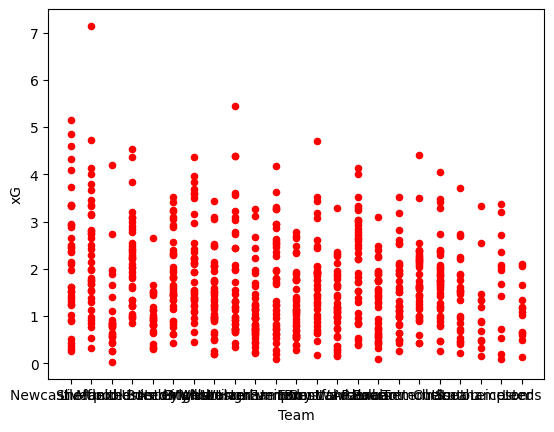

In [ ]:
# eng_df.plot.scatter(x='Team',y='xG',c='red')